# SARIMA 

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd

from itertools import product

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## Johnson and Johnson Quaterly Earnings

In [3]:
data = pd.read_csv('./data/jj.csv')
data.head()

,date,data
0,1960-01-01,0.71
1,1960-04-01,0.63
2,1960-07-02,0.85
3,1960-10-01,0.44
4,1961-01-01,0.61


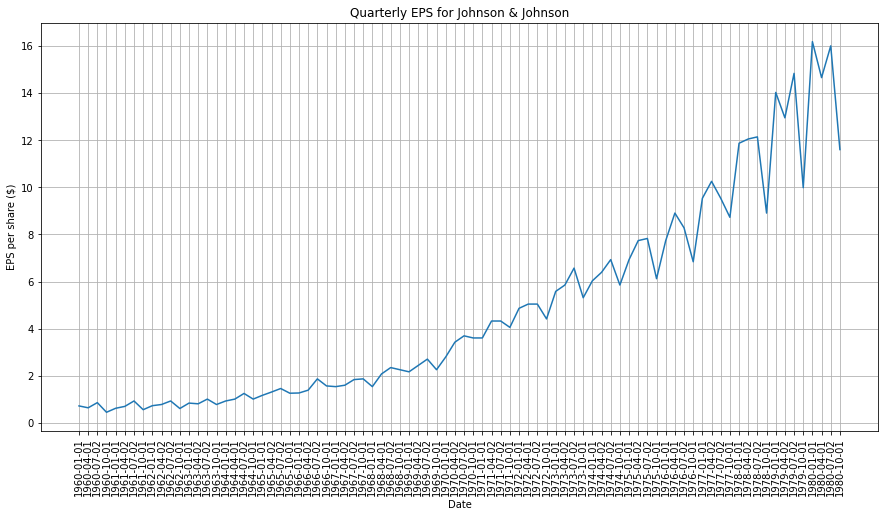

In [5]:
plt.figure(figsize=[15, 7.5]); # Set dimensions for figure
plt.plot(data['date'], data['data'])
plt.title('Quarterly EPS for Johnson & Johnson')
plt.ylabel('EPS per share ($)')
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

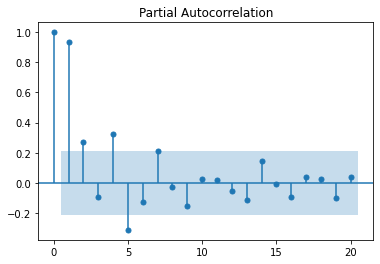

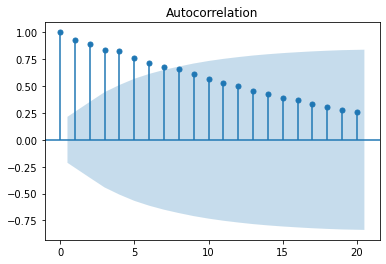

In [6]:
plot_pacf(data['data']);
plot_acf(data['data']);

In [7]:
# Augmented Dickey-Fuller test

ad_fuller_result = adfuller(data['data'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: 2.7420165734574766
p-value: 1.0


In [8]:
# Take the log difference to make data stationary

data['data'] = np.log(data['data'])
data['data'] = data['data'].diff()
data = data.drop(data.index[0])

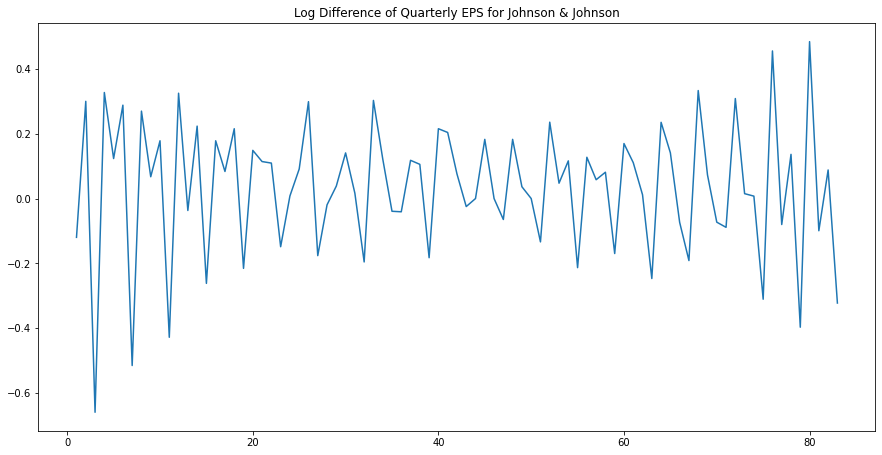

In [9]:
plt.figure(figsize=[15, 7.5]); # Set dimensions for figure
plt.plot(data['data'])
plt.title("Log Difference of Quarterly EPS for Johnson & Johnson")
plt.show()

In [10]:
# Seasonal differencing

data['data'] = data['data'].diff(4)
data = data.drop([1, 2, 3, 4], axis=0).reset_index(drop=True)
data.head()

,date,data
0,1961-04-02,0.242778
1,1961-07-02,-0.011834
2,1961-10-01,0.144006
3,1962-01-01,-0.057351
4,1962-04-02,-0.056093


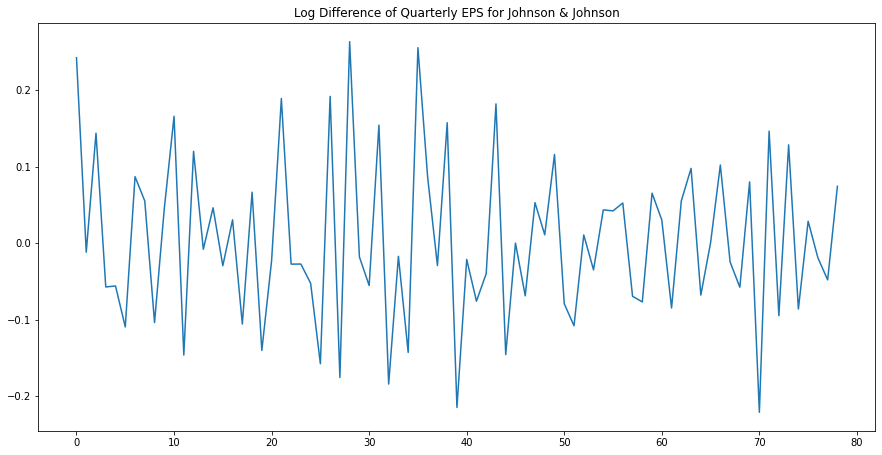

In [11]:
plt.figure(figsize=[15, 7.5]); # Set dimensions for figure
plt.plot(data['data'])
plt.title("Log Difference of Quarterly EPS for Johnson & Johnson")
plt.show()

In [12]:
# Augmented Dickey-Fuller test

ad_fuller_result = adfuller(data['data'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -6.630805109914262
p-value: 5.72157869513621e-09


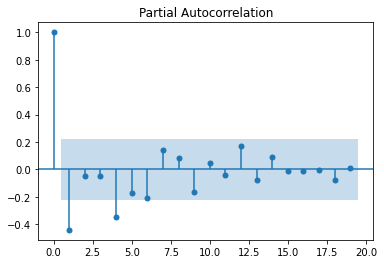

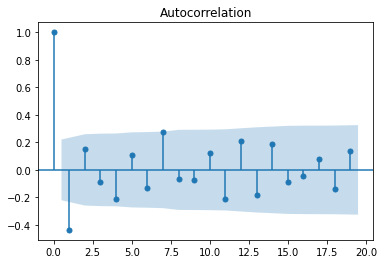

In [13]:
plot_pacf(data['data']);
plot_acf(data['data']);

In [14]:
def optimize_SARIMA(parameters_list, d, D, s, exog):
    """
        Return dataframe with parameters, corresponding AIC and SSE
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
        exog - the exogenous variable
    """
    
    results = []
    
    for param in tqdm_notebook(parameters_list):
        try: 
            model = SARIMAX(exog, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        results.append([param, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)x(P,Q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [15]:
p = range(0, 4, 1)
d = 1
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 1
Q = range(0, 4, 1)
s = 4

parameters = product(p, q, P, Q)
parameters_list = list(parameters)
print(len(parameters_list))

256


In [16]:
result_df = optimize_SARIMA(parameters_list, 1, 1, 4, data['data'])
result_df

,"(p,q)x(P,Q)",AIC
0,"(0, 2, 0, 2)",-114.463302
1,"(0, 2, 1, 2)",-114.254288
2,"(0, 2, 1, 3)",-113.492421
3,"(0, 2, 2, 2)",-113.093774
4,"(0, 2, 0, 3)",-113.076516
...,...,...
251,"(0, 0, 1, 1)",-24.752955
252,"(0, 0, 0, 1)",-23.122474
253,"(1, 0, 0, 0)",-19.068826
254,"(0, 0, 1, 0)",2.594264


In [17]:
best_model = SARIMAX(data['data'], order=(0, 1, 2), seasonal_order=(0, 1, 2, 4)).fit(dis=-1)
print(best_model.summary())

                                     SARIMAX Results                                     
Dep. Variable:                              data   No. Observations:                   79
Model:             SARIMAX(0, 1, 2)x(0, 1, 2, 4)   Log Likelihood                  62.232
Date:                           Sun, 21 Mar 2021   AIC                           -114.463
Time:                                   16:57:03   BIC                           -102.943
Sample:                                        0   HQIC                          -109.868
                                            - 79                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.5879      0.169     -9.421      0.000      -1.918      -1.258
ma.L2          0.5953      0.122      4.883

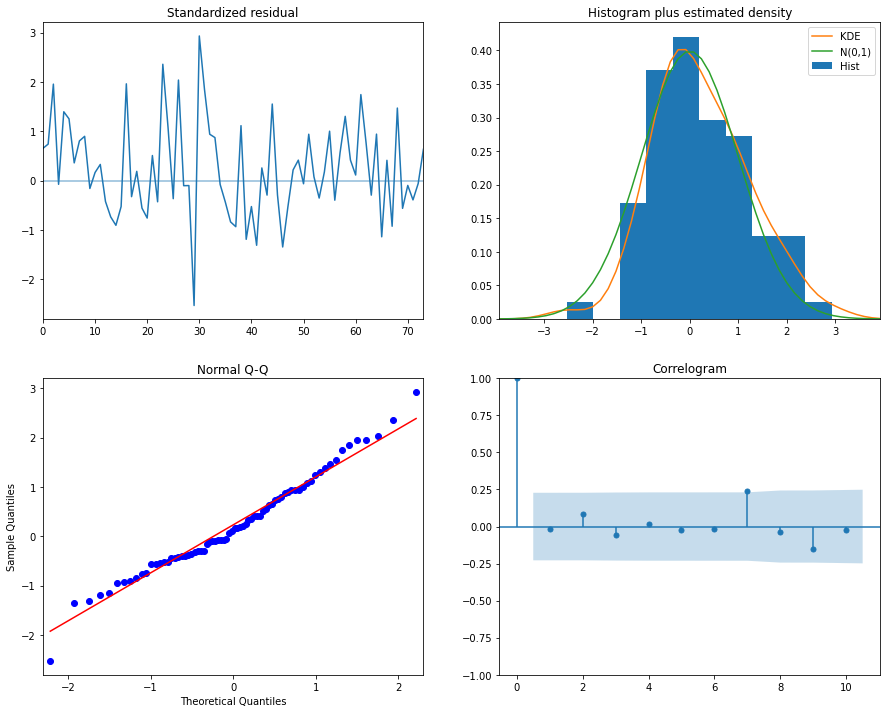

In [18]:
best_model.plot_diagnostics(figsize=(15,12));

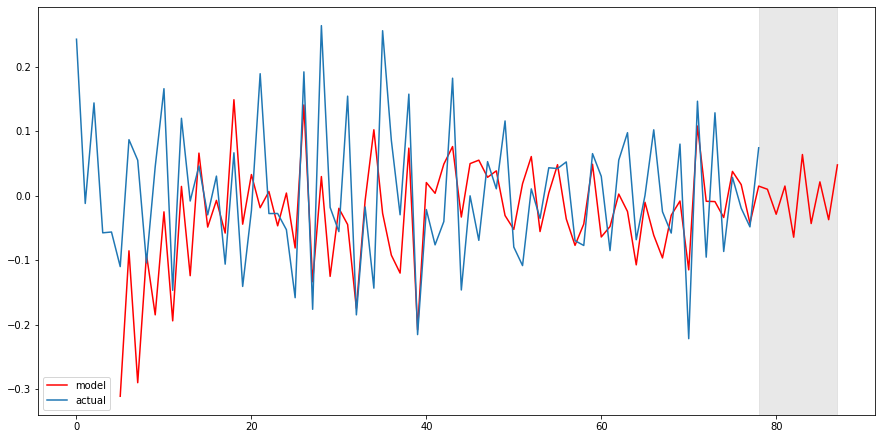

In [27]:
data['arima_model'] = best_model.fittedvalues
data['arima_model'][:4+1] = np.NaN # 첫 주기까지(여기서는 4)는 NaN으로 처리하는 듯

forecast = best_model.predict(start=data.shape[0], end=data.shape[0] + 8)
forecast = data['arima_model'].append(forecast)

plt.figure(figsize=(15, 7.5))
plt.plot(forecast, color='r', label='model')
plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
plt.plot(data['data'], label='actual')
plt.legend()

plt.show()

## Exponential Smoothing (Holt-Winters) 

In [27]:
data = pd.read_csv('jj.csv')
data.shape

(84, 2)

In [28]:
train, test = data.iloc[:75,:], data.iloc[75:,:]

In [32]:
model = ExponentialSmoothing(train['data'], seasonal='mul', seasonal_periods=4).fit()
pred = model.predict(start=test.index[0], end=test.index[-1])

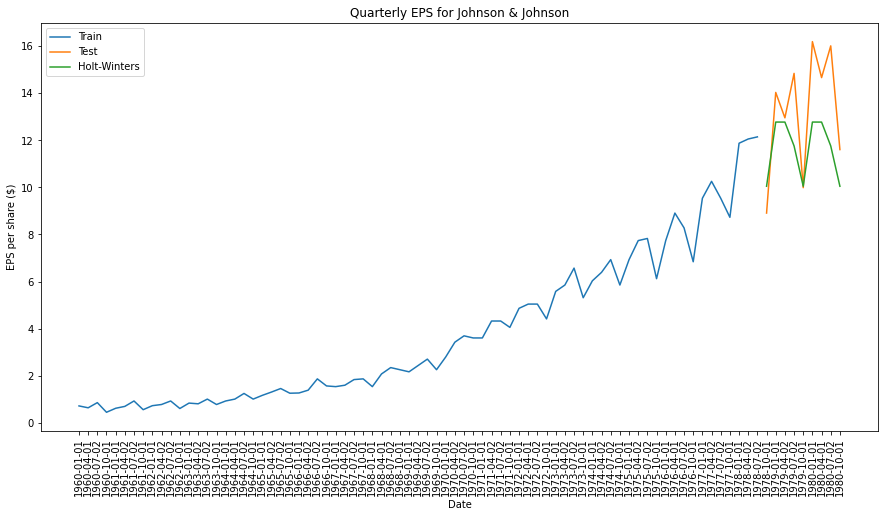

In [36]:
plt.figure(figsize=(15, 7.5))
plt.plot(train['date'], train['data'], label='Train')
plt.plot(test['date'], test['data'], label='Test')
plt.plot(pred.index, pred, label='Holt-Winters')
plt.title('Quarterly EPS for Johnson & Johnson')
plt.ylabel('EPS per share ($)')
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.legend()
plt.show()